# Figure 4: moBonita identifies mechanisms of hypoxia-mediated chemotaxis in RAMOS B cells 

* (a) Reduction of ERS – show ERS sizes of all three datasets on one plot 
* (b) Highly modulated nodes from the dataset – modulation score vs expression scatterplot 
* (c ) Pathway analysis from all three datasets on one plot 
* (d ) Subnetworks of influential genes from PKNs 

In [1]:
import seaborn as sns

In [2]:
print(sns.__version__)

0.11.1


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import statsmodels.stats.multitest
import os
import re
import requests
from ast import literal_eval
from glob import glob
from numpy import arange
import deap 

def getPathwayName(hsaURL):
    """Use KEGG API to get the readable name using the KEGG code (eg. hsa00010 corresponds to the glycolysis pathway)"""
    fileReg = re.compile("NAME\s+(\w+.*)")
    pathwayFile = requests.get("http://rest.kegg.jp/get/" + hsaURL,
                               stream=True)
    for line in pathwayFile.iter_lines():
        line = line.decode("utf-8")
        result = fileReg.match(line)
        if result:
            return result.group(1)
    return hsaURL

In [4]:
def processBonitaPvalues(pvalues,
                         adjustPvalue=True,
                         method=[
                             "bonferroni", "sidak", "holm-sidak", "sidak",
                             "simes-hochberg, hommel, fdr-bh", "fdr-by",
                             "fdr-tsbh", "fdr-tsbky"
                         ],
                         alpha=0.05):
    pvalues = pd.read_csv(
        pvalues, index_col=0).reset_index(drop=True).set_index("pathway")
    cols = [k for k in pvalues.columns if k not in ['pathway','code','nodes']]
    if adjustPvalue:
        for i in cols:
            pvalues[i] = np.power(10, -1 * pvalues[i])
            pvalues[i] = statsmodels.stats.multitest.multipletests(
                pvalues[i], method=method, is_sorted=False,
                returnsorted=False)[1]
            pvalues[i] = [(-1) * np.log10(j) for j in pvalues[i]]

    melt_pvalues = pvalues.reset_index().melt(id_vars='pathway',
                                              value_vars=cols)
    melt_pvalues = melt_pvalues[melt_pvalues.value > ((-1) * np.log10(alpha))]
    melt_pvalues = melt_pvalues.sort_values('value', ascending=False)
    melt_pvalues.columns = ("Pathway Name", "Condition", "value")
    return melt_pvalues

In [ ]:
pvalues = pd.read_csv(
        "pvalues_proteomics_20220601.csv", index_col=0).reset_index(drop=True).set_index("pathway")
cols = [k for k in pvalues.columns if k not in ['pathway','code','nodes']]
sns.__version__

In [ ]:
proteomics_pvalues = processBonitaPvalues(
    pvalues="pvalues_proteomics_20220601.csv",
    adjustPvalue=True,
    method='bonferroni',
    alpha=0.001)
#sns.set_theme(context='paper', style='ticks')
g = sns.scatterplot(data=proteomics_pvalues,
                    x='value',
                    y="Pathway Name",
                    hue="Condition",
                    palette="Greens",
                    s=75)
plt.legend(
    loc='upper center',  #'center left',  #
    bbox_to_anchor=(0.15, -0.15),  # (1.1, 0.6),  #
    fancybox=True,
    shadow=False,
    ncol=1,
    borderaxespad=0,
    facecolor="white")
plt.ylabel("")
plt.xlabel("-log10 (adjusted p-value)")
axes = plt.gca()
axes.yaxis.grid(color='grey', linestyle=(0, (5, 10)), linewidth=0.5)
g.figure.set_figheight(8)
g.figure.set_figwidth(5)
g.figure.tight_layout()
g.figure.savefig("proteomics_bonita.pdf")  #, height=10, width=4)
g.figure.savefig("proteomics_bonita.png", dpi=300)  #, height=10, width=4)

In [ ]:
transcriptomics_pvalues = processBonitaPvalues(
    pvalues="pvalues_transcriptomics_20220601.csv",
    adjustPvalue=False,
    alpha=0.05)
#sns.set_theme(context='paper', style='ticks')
g = sns.scatterplot(data=transcriptomics_pvalues,
                    x='value',
                    y="Pathway Name",
                    hue="Condition",
                    palette="Greens",
                    s=75)
plt.legend(
    loc='upper center',  #'center left',  #
    bbox_to_anchor=(0.15, -0.25),  # (1.1, 0.6),  #
    fancybox=True,
    shadow=False,
    ncol=1,
    borderaxespad=0,
    facecolor="white")
plt.ylabel("")
plt.xlabel("-log10 (p-value)")
axes = plt.gca()
axes.yaxis.grid(color='grey', linestyle=(0, (5, 10)), linewidth=0.5)
g.figure.set_figheight(4)
g.figure.set_figwidth(5)
g.figure.tight_layout()
g.figure.savefig("transcriptomics_bonita.pdf")  #, height=10, width=4)
g.figure.savefig("transcriptomics_bonita.png", dpi=300)  #, height=10, width=4)

In [ ]:
phosphoproteomics_pvalues = processBonitaPvalues(
    pvalues="pvalues_phosphoproteomics_20220601.csv",
    adjustPvalue=True,
    method='bonferroni',
    alpha=0.05)
#sns.set_theme(context='paper', style='ticks')
g = sns.scatterplot(data=phosphoproteomics_pvalues,
                    x='value',
                    y="Pathway Name",
                    hue="Condition",
                    palette="Greens",
                    s=75)
plt.legend(loc='upper center',
           bbox_to_anchor=(0.15, -0.25),
           fancybox=True,
           shadow=False,
           ncol=1,
           borderaxespad=0,
           facecolor="white")
plt.ylabel("")
plt.xlabel("-log10 (p-value)")
axes = plt.gca()
axes.yaxis.grid(color='grey', linestyle=(0, (5, 10)), linewidth=0.5)
g.figure.set_figheight(4)
g.figure.set_figwidth(5)
g.figure.tight_layout()
g.figure.savefig("phosphoproteomics_bonita.pdf")
g.figure.savefig("phosphoproteomics_bonita.png", dpi=300)

In [ ]:
concatenated_pvalues = processBonitaPvalues(
    pvalues="pvalues_concatenated_20220601.csv",
    adjustPvalue=False,
    alpha=0.1)
#sns.set_theme(context='paper', style='ticks')
g = sns.scatterplot(data=concatenated_pvalues,
                    x='value',
                    y="Pathway Name",
                    hue="Condition",
                    palette="Greens",
                    s=75)
plt.legend(loc='upper center',
           bbox_to_anchor=(0.15, -0.25),
           fancybox=True,
           shadow=False,
           ncol=1,
           borderaxespad=0,
           facecolor="white")
plt.ylabel("")
plt.xlabel("-log10 (p-value)")
axes = plt.gca()
axes.yaxis.grid(color='grey', linestyle=(0, (5, 10)), linewidth=0.5)
g.figure.set_figheight(4)
g.figure.set_figwidth(5)
g.figure.tight_layout()
g.figure.savefig("concatenated_bonita.pdf")
g.figure.savefig("concatenated_bonita.png", dpi=300)

In [ ]:
transcriptomics_pvalues["Dataset"] = "Transcriptomics"
phosphoproteomics_pvalues["Dataset"] = "Phosphoproteomics"
proteomics_pvalues["Dataset"] = "Proteomics"
concatenated_pvalues["Dataset"] = "Concatenated"
all_pvalues = pd.concat(
    [transcriptomics_pvalues, proteomics_pvalues, phosphoproteomics_pvalues, concatenated_pvalues])

In [ ]:
sns.set_theme(context='talk', style='ticks')
g = sns.relplot(
    data=all_pvalues,
    x='value',
    y="Pathway Name",
    col="Condition",
    #row="Dataset",
    hue="Dataset",
    palette="colorblind",
    s=75,
    facet_kws={
        'sharex': True,
        'sharey': False,
        'legend_out': True
    })
g.xlabel = "-log10 (adjusted p-value)"
g.ylabel = ""
g.figure.set_figheight(10)
g.figure.set_figwidth(30)
g.figure.tight_layout()
"""
for a in g.axes_dict:
    g.axes_dict[a].yaxis.grid(color='grey', linestyle=(0, (5, 10)), linewidth=0.5)
    g.axes_dict[a].xaxis.grid(color='grey', linestyle=(0, (5, 10)), linewidth=0.5)
"""
g.figure.savefig("all_pvalues_bonita.pdf")
g.figure.savefig("all_pvalues_bonita.png", dpi=300)

# Collect the *local1.pickle* files in the specified directory (change directory variable below)

directory = "/gpfs/fs2/scratch/mpalshik/multiomics_networks_2022/BONITA_experiments/"
outputfiles = []
for root, dirs, files in os.walk(directory):
    for f in files:
        if f.endswith("_local1.pickle"):
            outputfiles.append(os.path.join(root, f))
print(len(outputfiles), outputfiles[0:5])

# Open local1.pickle files and process the information into a single dataframe
**One row in the dataframe contains information for one node. The dataframe has the following columns:**
 - Network name - readable, descriptive KEGG network name
 - Method name - subfolder of the main directory in which the pickle was found
 - andNodeList - indices of parent nodes
 - andNodeInvertList - a bitstring encoding the activation and inhibition edges. True implies that the edge from the corresponding parent node in the andNodeList is an inhibitory edge
 - ruleLengths - length (ie, size) of the ERS for the node
 - equivs - bitstring representation of the equivalent rule set
 - plainRules - plain text representation of the rules in the ERS
 - randomERSIndividual - random individual from the ERS
 - minLocalSearchError - lowest error for the rules tried for each node

import pickle
from utils import *
from networkConstructor import *
from simulation import *
from pathway_analysis_score_pathways import *
from pathway_analysis_score_nodes import *
from GA import *
# from pathway_analysis_setup import *
import glob

def findEnds2(model, node, indiv):
    """ find the end of a node in the bitstring """
    node = model.nodeList.index(node)
    if node == len(model.nodeList) - 1:
        end1 = len(indiv)
    else:
        end1 = model.individualParse[node + 1]
    start1 = model.individualParse[node]
    return start1, end1

directory = "/gpfs/fs2/scratch/mpalshik/multiomics_networks_2022/BONITA_experiments/"
fileReg = re.compile('.*hsa(\d+)\_.+\.pickle')
seriesIndices = ["networkName", "methodName", "nodeList", "andNodeList", "andNodeInvertList", "ruleLengths", "equivs", "plainRules", "randomERSIndividual", "minLocalSearchError"]
df = pd.DataFrame(columns = seriesIndices)
i = 1
counter = 1
fileReg2 = re.compile(re.escape(directory) + r"(\w+.*)")
outputfiles = glob.glob("/gpfs/fs2/scratch/mpalshik/multiomics_networks_2022/BONITA_experiments/"+"*/pickles/*local1.pickle")

print(len(outputfiles))

for f in outputfiles:
    if (counter % 20 == 0):
        print(counter)
    counter = counter + 1
    getMethod=fileReg2.match(f)
    if getMethod:
        methodName=getMethod.group(1)
    else:
        methodName="N.A."
    result = fileReg.match(f)
    networkName = getPathwayName('hsa'+result.group(1))
    print(f)
    outputList = pickle.load(open(f, mode = "rb"))
    print(len(outputList))
    bruteOut1,dev,storeModel, storeModel3, equivalents, dev2 = [outputList[k] for k in range(len(outputList))]
    randomERSIndividual = bruteOut1 #random individual from the ERS
    minLocalSearchError = dev2 #lowest error for the rules tried for each node
    #equivalents = ERS for the network
    #storeModel = model from the GA
    minGAErrors = dev # minimum errors returned by the GA
    model1=modelHolder(storeModel3) #model from the local search
    for node in range(0,len(model1.nodeList)):
        plainRules=[]
        start1,end1=findEnds2(model1, model1.nodeList[node], equivalents[node])
        ers=equivalents[node] # find the bitstring for just this node
        #inEdges=findInEdges(model1, model1.nodeList.index(model1.nodeList[node]))
        for rule in ers:
            plainRules.append(writeNode(model1.nodeList.index(model1.nodeList[node]), rule, model1))
        ruleLengths=len(ers)
        ersAllNodes=plainRules
        s = pd.Series([networkName, methodName, model1.nodeList[node], model1.andNodeList[node], model1.andNodeInvertList[node], ruleLengths, str(ers), plainRules, randomERSIndividual, minLocalSearchError[node]], index = seriesIndices)
        df.loc[i] = s
        i = i + 1
df['methodName'] = df['methodName'].str.extract(r'(\w+)\/', expand=False)
df['indegree'] = [len(set([item for sublist in literal_eval(i) for item in sublist])) for i in df.andNodeList]
CSVfile = "local1Data.csv"
dfCSVFile = open(CSVfile, mode = "w")
df.to_csv(dfCSVFile)
dfCSVFile.close()


In [5]:
df = pd.read_csv("local1Data.csv", index_col=0)
df['indegree'] = [
    len(set([item for sublist in literal_eval(i) for item in sublist]))
    for i in df.andNodeList
]
df.head()

,networkName,methodName,nodeList,andNodeList,andNodeInvertList,ruleLengths,equivs,plainRules,randomERSIndividual,minLocalSearchError,indegree
1,Regulation of lipolysis in adipocytes - Homo s...,Proteomics,GNAS,[],[],1,[[]],['GNAS*= GNAS'],"[1, 0, 0]",0.000000,0
2,Regulation of lipolysis in adipocytes - Homo s...,Proteomics,LIPE,"[[3, 4], [3], [4]]","[[False, False], [False], [False]]",7,"[[1, 0, 0], [0, 1, 0], [1, 1, 0], [0, 0, 1], [...","['LIPE*=(PRKACA and PRKACB)', 'LIPE*=(PRKACA)'...","[1, 0, 0]",0.005106,2
3,Regulation of lipolysis in adipocytes - Homo s...,Proteomics,INSR,[],[],1,[[]],['INSR*= INSR'],"[1, 0, 0]",0.000000,0
4,Regulation of lipolysis in adipocytes - Homo s...,Proteomics,PRKACA,[],[],1,[[]],['PRKACA*= PRKACA'],"[1, 0, 0]",0.000000,0
5,Regulation of lipolysis in adipocytes - Homo s...,Proteomics,PRKACB,[],[],1,[[]],['PRKACB*= PRKACB'],"[1, 0, 0]",0.000000,0


AttributeError: 'FacetGrid' object has no attribute 'figure'

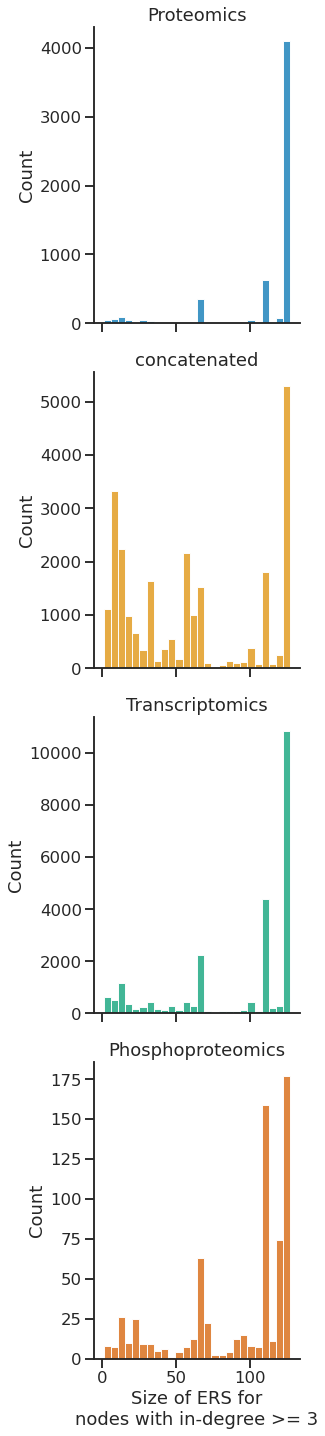

In [7]:
sns.set_theme(context='talk', style='ticks', rc={'figure.figsize': (1, 1)}) #sns.set_theme
g = sns.displot(
    data=df[df.indegree >= 3],
    x="ruleLengths",
    #multiple="stack",
    row="methodName",
    hue="methodName",
    palette="colorblind",
    legend=False,
    stat="count",
    facet_kws={
        'sharey': False,
        'sharex': True
    })
g.set_axis_labels("Size of ERS for\nnodes with in-degree >= 3", "Count")
g.set_titles("{row_name}")
g.figure.figsize = (1, 1)
g.savefig("figure3a.png", dpi=300)
g.savefig("figure3a.pdf")

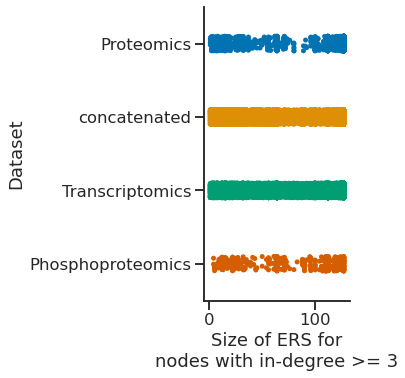

In [8]:
sns.set_theme(context='talk', style='ticks', rc={'figure.figsize': (1, 1)})
g = sns.catplot(data=df[df.indegree >= 3],
                x="ruleLengths",
                y="methodName",
                hue="methodName",
                palette="colorblind",
                legend=False)
g.set_axis_labels("Size of ERS for\nnodes with in-degree >= 3", "Dataset")
#g.set_titles("{col_name}")

In [9]:
transcriptomics = df[df['methodName'].str.contains('Transcriptomics')]
print(transcriptomics.shape)
phosphoproteomics = df[df['methodName'].str.contains('Phosphoproteomics')]
print(phosphoproteomics.shape)
proteomics = df[df['methodName'].str.match(
    'Proteomics'
)]  #note difference between contains and match - DO NOT CHANGE THIS
print(proteomics.shape)

(92700, 11)
(15100, 11)
(46360, 11)


In [10]:
# Get optimized networks
def maxERS(inDegree):
    if inDegree == 0:
        maxERS = 1
    else:
        inDegree = min(inDegree, 3)
        if inDegree == 2:
            maxERS = 15
        else:
            maxERS = 127
    return maxERS


df.loc[:, 'maxERS'] = [maxERS(i) for i in df.indegree]
df.loc[:, 'hasReducedERS'] = df.loc[:, 'ruleLengths'] < df.loc[:, 'maxERS']

# Compare importance scores



nodeTable = pd.DataFrame(index=["temp"],
                         columns=[
                             "andNode", "Display Name", "IS", "name", "RA",
                             "selected", "shared name", "Dataset", "Contrast",
                             "Network"
                         ])
for file in glob(
        "/gpfs/fs2/scratch/mpalshik/multiomics_networks_2022/BONITA_experiments/*/*/*rules.graphml"
):
    temp_df1 = pd.DataFrame(index=["temp"],
                            columns=[
                                "andNode", "Display Name", "IS", "name", "RA","Dataset",
                                "Contrast", "Network"
                            ])
    temp_G = nx.read_graphml(file)
    raw_table = list(temp_G.nodes.data())
    for node in raw_table:
        data = dict(node[1])
        temp_df2 = pd.DataFrame(data, index=[0])
        temp_df1 = pd.concat((temp_df1, temp_df2), axis=0)
    temp_df1 = temp_df1.iloc[1:]
    temp_df1 = temp_df1[temp_df1["andNode"] == 0]
    temp_df1.drop(temp_df1.columns[[0, 3, 5, 6]], axis=1, inplace=True)
    temp_df1.index = arange(1, len(temp_df1) + 1)
    filename = filepath = ''
    parsed1 = file.split('/')
    temp_df1["Dataset"] = parsed1[7]
    temp_df1["Contrast"] = parsed1[8]
    temp_df1["Network"] = parsed1[9].replace("_rules.graphml", "")
    #parsed2 = parsed1[3:]
    #parsed3 = parsed2[0].split(
    #    '_')[0][:2] + '_' + parsed2[1] + '_' + parsed2[2][:-14]
    #parsed4 = parsed3.replace('percent', '')
    #filename = parsed4.replace('-', '_')
    #filepath = '/'.join(parsed1[:3]) + "/Node_Tables/"
    #destination = filepath + filename
    #print(filename)
    #temp_df1.to_csv(destination)
    nodeTable = pd.concat([nodeTable, temp_df1])
nodeTable = nodeTable.dropna(axis=0, how='all')
nodeTable.to_csv("node_table.csv")
nodeTable

In [11]:
nodeTable = pd.read_csv("node_table.csv", index_col = 0)

In [12]:
nt2 = nodeTable[['Display Name', 'IS', 'Dataset', 'Network']].drop_duplicates()
nt2 = nt2.pivot_table(values="IS", index = ["Display Name", "Network"], columns = "Dataset")
nt2 = nt2.dropna(axis = 0, how = 'any')
nt2

Dataset                Phosphoproteomics  Proteomics  Transcriptomics  \
Display Name Network                                                    
ABI1         hsa05132           0.555900    0.251409         0.165745   
ACACA        hsa00061           1.000000    1.000000         1.000000   
             hsa00620           0.333467    0.065424         0.172884   
             hsa04152           0.050915    0.034890         0.028575   
             hsa04910           0.100531    0.103882         0.014030   
...                                  ...         ...              ...   
WAS          hsa04530           0.583581    0.318001         0.038634   
             hsa04666           1.000000    0.348217         0.228264   
             hsa05135           0.400205    0.326455         0.027357   
WEE1         hsa05170           0.334035    0.111485         0.028394   
YBX3         hsa04530           0.376692    0.280613         0.150776   

Dataset                concatenated  
Display Name Network                 
ABI1         hsa05132      0.124529  
ACACA        hsa00061      0.839025  
             hsa00620      0.066265  
             hsa04152      0.091814  
             hsa04910      0.023157  
...                             ...  
WAS          hsa04530      0.045139  
             hsa04666      0.176195  
             hsa05135      0.061632  
WEE1         hsa05170      0.038412  
YBX3         hsa04530      0.192288  

[997 rows x 4 columns]

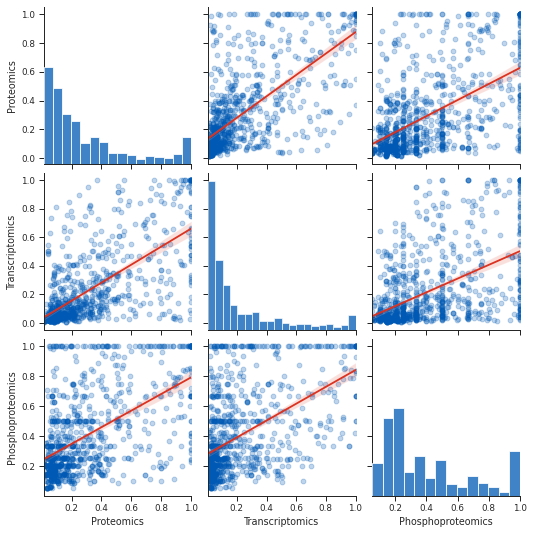

In [13]:
sns.set_context("paper")
g = sns.pairplot(nt2,
            x_vars = ["Proteomics", "Transcriptomics", "Phosphoproteomics"],
                 y_vars = ["Proteomics", "Transcriptomics", "Phosphoproteomics"],
             diag_kind='hist',
             kind='reg',
             plot_kws={
                 'scatter_kws': {
                     'alpha': 0.25,
                     'color': "#005AB5"
                 },
                 'line_kws': {
                     'color': '#DC3220'
                 }
             }, diag_kws = {'color': '#005AB5'},
             corner=False)
g.savefig("relation_between_importance_scores.png", dpi = 300)
g.savefig("relation_between_importance_scores.pdf")

In [14]:
from scipy.stats import spearmanr, pearsonr
print(spearmanr(nt2.Transcriptomics, nt2.Proteomics), pearsonr(nt2.Transcriptomics, nt2.Proteomics))
print(spearmanr(nt2.Transcriptomics, nt2.Phosphoproteomics), pearsonr(nt2.Transcriptomics, nt2.Phosphoproteomics))
print(spearmanr(nt2.Phosphoproteomics, nt2.Proteomics), pearsonr(nt2.Phosphoproteomics, nt2.Proteomics))

SpearmanrResult(correlation=0.707194759497439, pvalue=5.454417672907324e-152) (0.6851477281031549, 4.238259130091754e-139)
SpearmanrResult(correlation=0.5327834667110813, pvalue=3.4457516982212893e-74) (0.5196552553018026, 4.751700830313279e-70)
SpearmanrResult(correlation=0.5395417490309359, pvalue=2.1589901300453344e-76) (0.5565779408902296, 3.5730634213853924e-82)


In [15]:
commonNodesRules = df[df.nodeList.isin(
    nt2.index.get_level_values('Display Name').tolist())]
netid_to_name = {
    key: value
    for (key, value) in
    zip(set(nt2.index.get_level_values('Network')),
        [getPathwayName(f) for f in set(nt2.index.get_level_values('Network'))])
}
nt2['networkName'] = [netid_to_name[i] for i in nt2.index.get_level_values('Network')]
commonNodesRules = commonNodesRules[commonNodesRules.networkName.isin(
    nt2.networkName)].reset_index(drop=True)
commonNodesRules.head()

,networkName,methodName,nodeList,andNodeList,andNodeInvertList,ruleLengths,equivs,plainRules,randomERSIndividual,minLocalSearchError,indegree,maxERS,hasReducedERS
0,Calcium signaling pathway - Homo sapiens (human),Proteomics,PTK2B,[],[],1,[[]],['PTK2B*= PTK2B'],"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",0.0,0,1,False
1,Calcium signaling pathway - Homo sapiens (human),Proteomics,VDAC1,[],[],1,[[]],['VDAC1*= VDAC1'],"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",0.0,0,1,False
2,Calcium signaling pathway - Homo sapiens (human),Proteomics,VDAC2,[],[],1,[[]],['VDAC2*= VDAC2'],"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",0.0,0,1,False
3,Calcium signaling pathway - Homo sapiens (human),Proteomics,CAMK4,[],[],1,[[]],['CAMK4*= CAMK4'],"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",0.0,0,1,False
4,Calcium signaling pathway - Homo sapiens (human),Proteomics,PLCG2,[],[],1,[[]],['PLCG2*= PLCG2'],"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",0.0,0,1,False


In [18]:
cnr_transcriptomics = commonNodesRules[
    commonNodesRules['methodName'].str.contains('Transcriptomics')]
print(cnr_transcriptomics.shape)
cnr_phosphoproteomics = commonNodesRules[
    commonNodesRules['methodName'].str.contains('Phosphoproteomics')]
print(cnr_phosphoproteomics.shape)
cnr_proteomics = commonNodesRules[commonNodesRules['methodName'].str.match(
    'Proteomics'
)]  #note difference between contains and match - DO NOT CHANGE THIS
print(cnr_proteomics.shape)

(9230, 14)
(9230, 14)
(9230, 14)


In [19]:
tallyDF_final = commonNodesRules
tallyDF_final["percentOverlap"] = [np.nan for i in range(0, tallyDF_final.shape[0])]
print(tallyDF_final.shape)

(36920, 14)


In [20]:
def percentOverlap2(equivs, exactCompare=False):
    """Compare n lists to get a percentage overlap compared to the "universe" (i.e. the union of all n lists)"""
    overlap = set()
    universe = set()
    for l in equivs:
        rule = set([tuple(i) for i in l])
        universe = universe | rule
        if len(overlap) == 0:
            overlap = rule
        else:
            overlap = rule & overlap
    if len(universe) == 0:
        return(np.nan)
    else:
        if exactCompare:
            percentOverlap = float(len(overlap)) / len(universe) *100
        else:
            if len(overlap) > 0:
                return(float(1))
            else:
                return(float(0))
    return(percentOverlap)

In [21]:
def getNodeMinimalRule(ruleSet, andNodeList):
    numOrRules = [sum(ruleSet[j]) for j in range(len(ruleSet))]
    deciderVar = max(numOrRules)  # maximal or rules
    maxOrRules = ruleSet[
        numOrRules.index(deciderVar)
    ]  # rules with maximum or terms
    maxUpstreamNodes = 0
    minimalRule = []
    for orRule in [maxOrRules]:
        if sum(orRule) > 0:
            numUpstreamNodes = [
                andNodeList[orTerm]
                for orTerm in range(len(orRule))
                if orRule[orTerm] == 1
            ]
        else:
            minimalRule = orRule
            continue
        numUpstreamNodes = [len(element) for element in numUpstreamNodes]
        numUpstreamNodes = sum(numUpstreamNodes)
        if numUpstreamNodes > maxUpstreamNodes:
            maxUpstreamNodes = numUpstreamNodes
            minimalRule = orRule
        else:
            maxUpstreamNodes = maxUpstreamNodes
            minimalRule = minimalRule
    return minimalRule

In [ ]:
for network in list(set(commonNodesRules.networkName))[0:15]:
    print("############")
    print(network.upper())
    print("######\n")
    net_trans = cnr_transcriptomics[
        cnr_transcriptomics['networkName'].str.contains(network, regex=False)]
    net_phosph = cnr_phosphoproteomics[
        cnr_phosphoproteomics['networkName'].str.contains(network,
                                                          regex=False)]
    net_prot = cnr_proteomics[cnr_proteomics['networkName'].str.contains(
        network, regex=False)]
    allNodes = pd.concat(
        [net_trans.nodeList, net_phosph.nodeList, net_prot.nodeList])
    for node in set(allNodes):

        tempTrans = pd.DataFrame(net_trans[net_trans["nodeList"] == node])
        tempProt = pd.DataFrame(net_prot[net_prot["nodeList"] == node])
        tempPhosph = pd.DataFrame(net_phosph[net_phosph["nodeList"] == node])
        #print(tempTrans.shape, tempPhosph.shape, tempProt.shape)
        """
        percentOverlap = percentOverlap2([
            tempTrans.plainRules.tolist(),
            tempProt.plainRules.tolist(),
            tempPhosph.plainRules.tolist()
        ])
        if percentOverlap != 1:
            print(node, network)
            print([
                set(tempTrans.plainRules.tolist()),
                set(tempProt.plainRules.tolist()),
                set(tempPhosph.plainRules.tolist())
            ], percentOverlap)
        """
        minimalTrans = getNodeMinimalRule(
            literal_eval(tempTrans.equivs.iloc[0]),
            literal_eval(tempTrans.andNodeList.iloc[0]))
        minimalTrans = literal_eval(tempTrans.plainRules.iloc[0])[literal_eval(
            tempTrans.equivs.iloc[0]).index(minimalTrans)]
        minimalProt = getNodeMinimalRule(
            literal_eval(tempProt.equivs.iloc[0]),
            literal_eval(tempProt.andNodeList.iloc[0]))
        minimalProt = literal_eval(tempProt.plainRules.iloc[0])[literal_eval(
            tempProt.equivs.iloc[0]).index(minimalProt)]
        minimalPhosph = getNodeMinimalRule(
            literal_eval(tempPhosph.equivs.iloc[0]),
            literal_eval(tempPhosph.andNodeList.iloc[0]))
        minimalPhosph = literal_eval(tempPhosph.plainRules.iloc[0])[literal_eval(
            tempPhosph.equivs.iloc[0]).index(minimalPhosph)]
        print(node)
        print("Trans: ", minimalTrans, "\nProt:", minimalProt, "\nPhosph:",
              minimalPhosph)
        print("######\n")

In [22]:
minimalTrans = "RB1*=(CDKN1A) or (CDK2 and CDKN1A) or (CDK2)"
minimalProt = "RB1*=(GRB2) or (TP53 and CDK2 and GRB2) or (TP53 and CDK2) or (TP53 and GRB2) or (TP53) or (CDK2 and GRB2) or (CDK2)"
minimalPhosph = "RB1*=(not PTK2B) or (not TP53 and  not MAP3K7 and  not PTK2B) or (not TP53 and  not MAP3K7) or (not TP53) or (not MAP3K7 and  not PTK2B) or (not MAP3K7)"

# simple intersection
def makeRuleList(rule):
    line=rule
    line=line.strip()
    matcher=re.search("(.*)\*=(.*)", line)
    node=matcher.group(1).strip()
    rule=matcher.group(2).strip()
    preds=re.sub("and|not|or|\(|\)", "", rule)
    preds=preds.strip()
    preds=re.sub("\s+", ",", preds)
    preds=tuple(preds.split(","))
    rule=rule.split(" or ")
    return rule, preds
    
transRule, transPreds = makeRuleList(minimalTrans)
protRule, protPreds = makeRuleList(minimalProt)
phosphRule, phosphPreds = makeRuleList(minimalPhosph)

print(set(transRule),set(protRule),set(phosphRule))
print(set(transRule) & set(protRule) & set(phosphRule))

{'(CDKN1A)', '(CDK2 and CDKN1A)', '(CDK2)'} {'(GRB2)', '(TP53 and GRB2)', '(CDK2 and GRB2)', '(TP53)', '(TP53 and CDK2 and GRB2)', '(TP53 and CDK2)', '(CDK2)'} {'(not MAP3K7)', '(not TP53 and  not MAP3K7 and  not PTK2B)', '(not MAP3K7 and  not PTK2B)', '(not TP53 and  not MAP3K7)', '(not PTK2B)', '(not TP53)'}
set()


In [26]:
set(transRule).union(set(protRule)).union(set(phosphRule))

{'(CDK2 and CDKN1A)',
 '(CDK2 and GRB2)',
 '(CDK2)',
 '(CDKN1A)',
 '(GRB2)',
 '(TP53 and CDK2 and GRB2)',
 '(TP53 and CDK2)',
 '(TP53 and GRB2)',
 '(TP53)',
 '(not MAP3K7 and  not PTK2B)',
 '(not MAP3K7)',
 '(not PTK2B)',
 '(not TP53 and  not MAP3K7 and  not PTK2B)',
 '(not TP53 and  not MAP3K7)',
 '(not TP53)'}

In [23]:
from utils import Get_expanded_network
Get_expanded_network([literal_eval(t)[0] for t in net_trans.plainRules.tolist()], equal_sign="*=").nodes


NameError: name 'net_trans' is not defined

In [ ]:
for network in list(set(commonNodesRules.networkName)):
    net_trans = cnr_transcriptomics[cnr_transcriptomics['networkName'].str.contains(network, regex=False)]
    net_phosph = cnr_phosphoproteomics[cnr_phosphoproteomics['networkName'].str.contains(network, regex=False)]
    net_prot = cnr_proteomics[cnr_proteomics['networkName'].str.contains(network, regex=False)]
    print(net_trans.shape)
    for node in set(df.nodeList):
        tempTrans = pd.DataFrame(net_trans[net_trans["nodeList"] == node])
        tempProt = pd.DataFrame(net_prot[net_prot["nodeList"] == node])
        tempPhosph = pd.DataFrame(net_phosph[net_phosph["nodeList"] == node])
        if (net_trans.shape[0] >= 0 and net_prot.shape[0] >= 0 and net_phosph.shape[0]>= 0):
            percentOverlap = percentOverlap2([tempTrans.plainRules.tolist(), tempProt.plainRules.tolist(), tempPhosph.plainRules.tolist()])
            temp2 = [t1 & t2 for t1, t2 in zip(list(tallyDF_final["networkName"]== network), list(tallyDF_final["nodeList"] == node))]
            tallyDF_final.loc[temp2, "percentOverlap"] = percentOverlap

In [ ]:
tallyDF_final.head()
tallyDF_final.to_csv("tallyDF.csv")
"""Aggregate by network and show average percent overlap"""
temp1 = pd.DataFrame(tallyDF_final.groupby(["networkName"]).mean())
temp1.head()